In [1]:
import numpy as np
import os
import pandas as pd
import random
import soundfile as sf
import tqdm
import uuid


data_dir = '/beegfs/vl1019/BirdVox_datasets/'

in_name = "BirdVox-full-night"
out_name = "BirdVox-DCASE-20k"
in_sr = 24000.0
out_sr = 44100.0
in_dir = os.path.join(data_dir, in_name)
out_dir = os.path.join(data_dir, out_name)
os.makedirs(out_dir, exist_ok=True)
units = ["unit" + str(n).zfill(2) for n in [1, 2, 3, 5, 7, 10]]

In [2]:
# We add 1299 ms to every hop
# to avoid synchronizing the start of items
# with the clock of the device and to
# have precisely 20,000 items.

item_duration = 10 # in seconds
hop_duration = item_duration + 1.299
    
private_df = pd.DataFrame(columns=[
    "Unit", "Item start (s)", "Has bird", "#Calls", "UUID", "Call timestamps (s)"]
)

out_private_dir = os.path.join(out_dir,
    out_name + "_csv-private")
os.makedirs(out_private_dir, exist_ok=True)

keygen_path = "/beegfs/vl1019/BirdVox_datasets/BirdVox-DCASE-20k_keygen.txt"
with open(keygen_path, 'r') as keygen_file:  
    private_key_str = keygen_file.read()
    private_key_str = private_key_str.replace("\n", "")
    private_key_list = list(map(ord, private_key_str))
    private_key_nb = sum([private_key_list[i]*(256**i) for i in range(len(private_key_list))])
    private_key_nb = np.mod(private_key_nb, 4294967295)
random.seed(private_key_nb)

extra_positives_path = "/beegfs/vl1019/BirdVox_datasets/BirdVox-DCASE-20k/BirdVox-DCASE-20k_csv-private/extra_positives.md"
with open(extra_positives_path, 'r') as infile:
    data = infile.read()
extra_region_strs = [x.split("\n") for x in data.split("**")[2::2]]
extra_regions = []

for unit_extra_region_strs in extra_region_strs:
    
    unit_extra_regions = []
    for extra_region_str in unit_extra_region_strs:
        if extra_region_str == "":
            continue

        extra_region_split = extra_region_str.split("->")
        extra_region_split = list(map(lambda s: s.replace(" ", ""), extra_region_split))
        start_split = list(map(int, extra_region_split[0].split(":")))
        start = start_split[0]*3600 + start_split[1]*60 + start_split[2]
        stop_split = list(map(int, extra_region_split[1].split(":")))
        stop = stop_split[0]*3600 + stop_split[1]*60 + stop_split[2]
        unit_extra_regions.append((start, stop))
        
    extra_regions.append(unit_extra_regions)


for unit_id, unit_str in enumerate(units): 
    # Open CSV annotations.
    in_csv_dir = os.path.join(in_dir, "BirdVox-full-night_csv-annotations")
    in_csv_path = os.path.join(in_csv_dir,
        "BirdVox-full-night_csv-annotations_" + unit_str + ".csv")
    in_csv_df = pd.read_csv(in_csv_path)
    in_times = np.array(in_csv_df["Time (s)"])

    # Open FLAC file.
    in_flac_dir = os.path.join(in_dir, "BirdVox-full-night_flac-audio")
    in_flac_path = os.path.join(in_flac_dir,
        "BirdVox-full-night_flac-audio_" + unit_str + ".flac")
    in_flac = sf.SoundFile(in_flac_path)
    in_duration = len(in_flac) / in_sr
    
    unit_extra_regions = extra_regions[unit_id]

    # Loop over items
    n_items = int((in_duration-item_duration) / hop_duration)
    for item_id in tqdm.tqdm(range(n_items)):
        # Guarantee a 200 millisecond minimum time span between items
        item_start = item_id * hop_duration + 0.1
        item_stop = item_start + hop_duration - 0.1
        
        has_extra_bird = False
        for region in unit_extra_regions:
            region_start = region[0]
            region_stop = region[1]
            has_bird_left =\
                (region_stop > (item_start + 1.0)) and (region_start < (item_start + 9.0))
            has_bird_right =\
                (region_stop > (item_stop - 9.0)) and (region_start < (item_stop - 1.0))
            if has_bird_left or has_bird_right:
                has_extra_bird = True
                break

        if not has_bird_left:
            has_bird_left = any((in_times > (item_start + 1.0)) & (in_times < (item_start + 9.0)))
            
        if not has_bird_right:
            has_bird_right = any((in_times > (item_stop - 9.0)) & (in_times < (item_stop - 1.0)))

        # Alternate left truncation and right truncation depending on item parity
        if not has_bird_left and not has_bird_right:
            if (item_id % 2) == 0:
                item_stop = item_start + 10.0
            else:
                item_start = item_stop - 10.0
            call_timestamps = []
        else:
            if has_bird_left and has_bird_right:
                if (item_id % 2) == 0:
                    item_stop = item_start + 10.0
                else:
                    item_start = item_stop - 10.0
            elif has_bird_left:
                item_stop = item_start + 10.0
            elif has_bird_right:
                item_start = item_stop - 10.0
            call_timestamps = sorted(in_times[(in_times > item_start) & (in_times < item_stop)] - item_start)


        a = "%32x" % random.getrandbits(128)
        rd = a[:12] + '4' + a[13:16] + 'a' + a[17:]
        uuid4 = str(uuid.UUID(rd))

        # Append row to DataFrame
        n_calls = len(call_timestamps)
        has_bird = has_extra_bird or (n_calls > 0)
        row = pd.DataFrame({
            "Unit": [unit_str],
            "Item start (s)": ["{:9.3f}".format(item_start)],
            "Has bird": [int(has_bird)],
            "#Calls": [n_calls],
            "UUID": [uuid4],
            "Call timestamps (s)": [["{:5.3f}".format(t) for t in call_timestamps]]
        }, columns = [
            "Unit", "Item start (s)", "Has bird", "#Calls", "UUID", "Call timestamps (s)"])
        private_df = private_df.append(row)
        
        
# Export private CSV.
private_csv_name = "BirdVox-full-night_csv-private.csv"
private_csv_path = os.path.join(out_private_dir, private_csv_name)
private_df.to_csv(private_csv_path, index=False)


# Remove quotes.
with open(private_csv_path, 'r') as infile, open(private_csv_path[:-4] + "_noquotes.csv", 'w') as outfile:
    data = infile.read()
    data = data.replace("\"", "")
    data = data.replace("\'", "")
    outfile.write(data)

100%|██████████| 2608/2608 [00:13<00:00, 196.59it/s]


In [32]:
from itertools import islice 
import random
import sox

private_df = pd.read_csv("/beegfs/vl1019/BirdVox_datasets/BirdVox-DCASE-20k/BirdVox-DCASE-20k_csv-private/BirdVox-full-night_csv-private.csv")
sorted_df = private_df.sort_values("UUID")
n_rows = len(sorted_df)

in_dir = '/beegfs/vl1019/BirdVox_datasets/BirdVox-full-night/BirdVox-full-night_flac-audio'
wav_dir = os.path.join(out_dir, "wav")
os.makedirs(wav_dir, exist_ok=True)

row_list = list(range(n_rows))
random.shuffle(row_list)

for row_id in range(n_rows):
    row = private_df.iloc[row_list[row_id]]
    unit_str = row["Unit"]
    item_start = row["Item start (s)"]
    has_bird = row["Has bird"]
    uuid = row["UUID"]
    
    tfm = sox.Transformer()
    tfm.trim(item_start, item_start + item_duration)
    tfm.gain(gain_db=-2.0, normalize=True)
    tfm.convert(samplerate=44100)
    
    in_name = "BirdVox-full-night_flac-audio_" + unit_str + ".flac"
    in_path = os.path.join(in_dir, in_name)
    out_path = os.path.join(wav_dir, uuid + ".wav")
    tfm.build(in_path, out_path);

In [41]:
hasbird_list

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [85]:
private_path = '/beegfs/vl1019/BirdVox_datasets/BirdVox-DCASE-20k/BirdVox-DCASE-20k_csv-private/BirdVox-full-night_csv-private.csv'
public_path = '/beegfs/vl1019/BirdVox_datasets/BirdVox-DCASE-20k/BirdVox-DCASE-20k_csv-private/BirdVox-full-night_csv-public.csv'

import pandas as pd
in_df = pd.read_csv(out_path)
itemid_df =  pd.DataFrame(list(in_df["UUID"]), columns=["itemid"])
hasbird_df = pd.DataFrame(list(in_df["Has bird"]), columns=["hasbird"])
n_rows = len(hasbird_list)
datasetid_df = pd.DataFrame(["BirdVox-DCASE-20k"] * n_rows, columns=["datasetid"])
out_df = pd.concat(
    [itemid_df, datasetid_df, hasbird_df],
    axis=1)
out_df = out_df.sort_values("itemid")
out_df.to_csv(public_path, index=False)

In [86]:
out_df

,itemid,datasetid,hasbird
8286,00053d90-e4b9-4045-a2f1-f39efc90cfa9,BirdVox-DCASE-20k,1
5369,000db435-a40f-4ad9-a74e-d1af284d2c44,BirdVox-DCASE-20k,0
3266,001059c0-e04f-42fc-a8e2-11aad24dc6fb,BirdVox-DCASE-20k,1
11270,00106202-f61e-467d-a80f-070d90421952,BirdVox-DCASE-20k,0
19755,00129593-77ca-40b2-a512-75d178071250,BirdVox-DCASE-20k,0
10540,00143c1f-bcac-47f6-a83d-81b2975ccca3,BirdVox-DCASE-20k,0
5232,00160fdf-5231-461b-acd7-1db41abf3ee5,BirdVox-DCASE-20k,1
2292,00162d26-57e6-4924-a247-5f58963f1403,BirdVox-DCASE-20k,0
19478,001ac3fe-c23a-4366-a16d-8d59f021b17e,BirdVox-DCASE-20k,0
14261,001ac895-0e9c-41d8-a76c-65c73c4a8d11,BirdVox-DCASE-20k,0


In [33]:
from collections import Counter
import numpy as np

X = np.array(out_df.sort_values("UUID")["Has bird"])
X = np.reshape(X, (5, 4000))
X_list = ["".join(map(str,X[:, i])) for i in range(X.shape[1])]
print(Counter(X_list))

Counter({'11100': 142, '00110': 142, '00010': 141, '10011': 139, '11011': 139, '10101': 136, '01110': 136, '10111': 134, '11010': 134, '10010': 133, '01001': 133, '11001': 133, '00100': 132, '11101': 130, '00011': 130, '10000': 125, '01100': 124, '00001': 123, '01000': 123, '11110': 122, '01011': 120, '00101': 120, '01010': 116, '11000': 116, '01111': 115, '11111': 115, '10001': 113, '00000': 110, '10100': 108, '01101': 107, '10110': 106, '00111': 103})


In [5]:
from collections import Counter
Counter(list(private_df.loc[(private_df["Has bird"] == True) & (private_df["#Calls"] == 0)]["Unit"]))

Counter({'unit02': 9, 'unit03': 48, 'unit05': 11, 'unit07': 10, 'unit10': 11})

In [4]:
sum(private_df["Has bird"])

10017

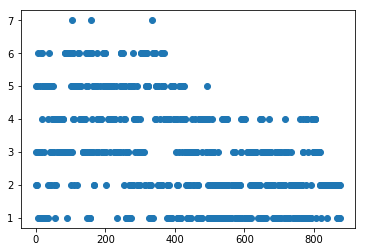

In [57]:
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline

starts = np.array(private_df["Item start (s)"])

plt.plot(np.array(list(Counter((1000 * (starts - np.floor(starts))).astype('int')).values())), 'o')